# Text2StereoWithBaseline

### Delete Files
Delete unnecessary files.

In [1]:
!rm -rf /content/sample_data
!rm -rf /content/__MACOSX/
!rm -rf /content/lora_out
!rm -rf /content/output
!rm -rf /content/fixed_baselines.zip

### Mount Google Drive

We mount the google drive folder, s.t. we have access to the training data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [3]:
import os, json, math, random, torch
from collections import defaultdict
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Sampler
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, DDPMScheduler
from torch import nn, optim
from tqdm import tqdm
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict

### Configuration

In [4]:
# directories
DATA_DIR   = "/content/drive/MyDrive/Colab Notebooks/fixed_baselines"
MODEL_ID   = "runwayml/stable-diffusion-v1-5"
HF_CACHE   = "/content/hf_cache"
OUTPUT_DIR = "/content/lora_out"

# LoRa
R_UNET     = 16 # rank unet
R_TE       = 8  # rank text-encoder
LR         = 3e-5
BATCHSIZE  = 1
IMAGE_SIZE = (384, 384)

# training
STEPS_PER_EPOCH  = 2000
MAX_STEPS        = 25000
GRAD_ACCUM       = 4
WEIGHT_DECAY     = 1e-2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
assert DEVICE == "cuda", "Runtime -> Change runtime type -> GPU"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(HF_CACHE, exist_ok=True)

### Helpers

In [5]:
# returns baseline/fov for a meta file
def _read_meta(meta_path):
    baseline, fov = 0.08, 60.0
    if os.path.exists(meta_path):
        with open(meta_path, "r") as f:
            m = json.load(f)

        if "baseline_m" in m:
          baseline = float(m["baseline_m"])

        if "fov_deg"   in m:
          fov = float(m["fov_deg"])

        # Fallbacks
        # No FOV in meta file
        if (m.get("fov_deg") is None) and "fx" in m and "width" in m:
            # calculate fov from width and focal length
            fov = math.degrees(2.0 * math.atan((float(m["width"])*0.5)/float(m["fx"])))

        # No baseline in meta file
        if (m.get("baseline_m") is None) and "cam_left" in m and "cam_right" in m:
            # calculate baseline from x coordinates of both cameras
            try:
                tx_l = float(m["cam_left"]["matrix_world"][0][3])
                tx_r = float(m["cam_right"]["matrix_world"][0][3])
                baseline = abs(tx_r - tx_l)
            except Exception:
                pass
    return max(0.01, min(1.0, baseline)), max(20.0, min(120.0, fov))





def get_prompt_embeds(pipe, prompts, device):
    try:
        enc = pipe.encode_prompt(
            prompts,
            device=device,
            num_images_per_prompt=1,
            do_classifier_free_guidance=False,
            negative_prompt=None,
        )
        return enc[0] if isinstance(enc, tuple) else enc
    except Exception:
        tok = pipe.tokenizer(
            prompts, padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True, return_tensors="pt",
        )
        input_ids = tok.input_ids.to(device)
        with torch.no_grad():
            enc = pipe.text_encoder(input_ids)[0]
        return enc

### Dataset
We need to describe our stereo dataset. To do this we collect the most important properties of the images in `self.samples`. For each image (left or right) we will save
- `image path`
- `prompt`
- `btag` (baseline)

inside of a dictionary.

We currently don't know the implications of very large baselines. Since earlier trainigsdata may include stereo images with large baselines, we will ignore all stereo images with a baseline larger then `0.2`.
We currently also ignore the `fov` property of the meta data.

In [6]:
class StereoScenesDataset(Dataset):
    def __init__(self, root_dir, size=(384, 384)):
        self.root_dir = root_dir
        self.size = size
        # collecting all scenes
        self.samples = self._collect()

    def _find(self, d, scene, tag):
        for ext in (".png", ".jpg", ".jpeg"):
            p = os.path.join(d, f"{scene}_{tag}{ext}")
            if os.path.exists(p):
              return p
        return None

    def _collect(self):
        S = []
        # collecting all image
        for scene in sorted(os.listdir(self.root_dir)):
            d = os.path.join(self.root_dir, scene)
            if not os.path.isdir(d):
              continue
            # path left, right
            L = self._find(d, scene, "left")
            R = self._find(d, scene, "right")
            # skip if not left and right
            if not (L and R):
              continue
            # meta
            meta = os.path.join(d, f"{scene}_meta.json")
            # baseline (ignore fov)
            B, _ = _read_meta(meta) if os.path.exists(meta) else (0.08, 60.0)

            # ignore too large baselines
            if B > 0.20:
              continue

            btag = f"<B_{int(round(B*100)):02d}>"

            # baseline tokens + side tokens
            S += [
                {"image_path": L, "prompt": f"{btag} <LEFT>",  "btag": btag},
                {"image_path": R, "prompt": f"{btag} <RIGHT>", "btag": btag},
            ]
        if not S:
            raise RuntimeError(f"No scene pairs found under {self.root_dir}")
        return S

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img = Image.open(s["image_path"]).convert("RGB").resize(self.size)
        return {"image": img, "prompt": s["prompt"], "btag": s["btag"]}

### Baseline Sampling
Since we strive for an uniform distribution of baselines in our trainingsdata, we would like to categorize the images in baseline buckets.
For example:
```
self.buckets["<B_06>"] = [0, 5, 9, ...]
self.buckets["<B_08>"] = [1, 3, 7, ...]
```
this allows us to uniformly train our model without distribution bias which could result from non-uniform trainings data.

In [7]:
class BalancedByBaselineSampler(Sampler):
    """Round-robin über Baseline-Buckets; pro Step zufälliger Index aus Bucket."""
    def __init__(self, samples, batch_size=1, steps_per_epoch=2000):
        self.buckets = defaultdict(list)
        for i, s in enumerate(samples):
            self.buckets[s["btag"]].append(i)
        self.keys = sorted(self.buckets.keys())
        self.batch_size = batch_size
        self.steps = steps_per_epoch

    def __iter__(self):
        k = 0
        for _ in range(self.steps * self.batch_size):
            key = self.keys[k % len(self.keys)]
            yield random.choice(self.buckets[key])
            k += 1

    def __len__(self):
        return self.steps * self.batch_size

### Base Pipeline
Now we need to load the Stable Diffusion pipeline from the pretrained model `stable-diffusion-v1-5` from HF.
Important terms:

`Text Encoder`: Representation of ***text prompt*** in UNet. Translates prompt into embeddings, consumed by UNet (numerical vector).

Prompt → Tokenizer → Token-IDs → Text-Encoder → Embeddings → UNet

`VAE`: Representation of ***image pixels*** in UNet. Translates image pixels into feature map, consumed by UNet.

Image → VAE-Encoder → Latent → UNet → denoised Latent → VAE-Decoder → Image

`UNet`: Diffusion network, resposible for denoising the image in each step.

(noisy latent + timestep, text embeddings) → UNet → predicted noise → (iterative denoising) → final latent → VAE-Decoder → Image





In [8]:
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    cache_dir=HF_CACHE,
    safety_checker=None,
    requires_safety_checker=False
)

# faster image generation
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# reduces VRAM usage
pipe.enable_vae_tiling()
pipe.vae.enable_slicing()
pipe.enable_attention_slicing()

# execute pipeline on GPU
pipe.to("cuda")

# use float16 for faster image generation
for m in [pipe.unet, pipe.vae, pipe.text_encoder]:
    m.to(device="cuda", dtype=torch.float16)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### LoRa Configs

We use `stable-diffusion-v1-5` as our base model and add LoRa Layer on top. Before we do this we will freeze the parameters of our base model. This way only the newly added LoRA weights are trained.



In [9]:
# freeze parameters (UNet, VAE, text encoder) of our base model
for p in pipe.unet.parameters(): p.requires_grad_(False)
for p in pipe.vae.parameters():  p.requires_grad_(False)
for p in pipe.text_encoder.parameters(): p.requires_grad_(False)

now we will configure how the LoRa layers are added (for the UNet and the text-encoder). We define the following parameters:
- `r` rank of matrices → Increasing `r` increase number of parameters.
- `lora_alpha` scale factor of activation → Increases LoRa activation without more parameters.
- `lora_dropout` can be ignored for stable diffusion.
- `bias` none standard for stable diffusion.
- `target_modules` baseline control acts on spacial relationships.
- `init_lora_weights` initializes weights with normal distribution.

In [10]:
# UNet-LoRA
lora_cfg_unet = LoraConfig(
    r=R_UNET,
    lora_alpha=R_UNET*2,
    lora_dropout=0.0,
    bias="none",
    target_modules=["to_q","to_k","to_v","to_out.0"],
    init_lora_weights="gaussian",
)
# add weights to target modules defined in cfg.
pipe.unet.add_adapter(lora_cfg_unet, adapter_name="stereo")
# LoRa is able to have several adapters. Here we add our stereo adapter.
pipe.unet.set_adapters(["stereo"])

# we saved our unet weights as float16 instead of float32 to make it faster.
UNET_DTYPE = next(pipe.unet.parameters()).dtype

# since lora weights are initialized as float32 we have to convert them
for n, p in pipe.unet.named_parameters():
    if "lora" in n: p.data = p.data.to(UNET_DTYPE)





# Text-Encoder-LoRA
te_lora = LoraConfig(
    r=R_TE,
    lora_alpha=R_TE*2,
    lora_dropout=0.0,
    bias="none",
    target_modules=["q_proj","k_proj","v_proj","out_proj"]
)
# add new weights to current text-encoder
pipe.text_encoder = get_peft_model(pipe.text_encoder, te_lora)
pipe.text_encoder.to(device="cuda", dtype=torch.float16)

PeftModel(
  (base_model): LoraModel(
    (model): CLIPTextModel(
      (text_model): CLIPTextTransformer(
        (embeddings): CLIPTextEmbeddings(
          (token_embedding): Embedding(49408, 768)
          (position_embedding): Embedding(77, 768)
        )
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-11): 12 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=768, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                  

### Baseline sampling - Applied
Now we load the data and register the new tokens. After that we generate uniform indice buckets for the baselines `<B_xx>` (see `BalancedByBaselineSampler`) and retrieve consecutively an index for the current baseline.

For example:
```
Step 1 → B_06 → 9
Step 2 → B_08 → 1
Step 3 → B_10 → 6
Step 4 → B_06 → 0
Step 5 → B_08 → 7
Step 6 → B_10 → 4
```

In [ ]:
# load dataset
ds = StereoScenesDataset(DATA_DIR, size=IMAGE_SIZE)

# register all baseline tokens <B_xx> and <LEFT>, <RIGHT> token
extra_tokens = sorted({s["btag"] for s in ds.samples} | {"<LEFT>", "<RIGHT>"})
added = pipe.tokenizer.add_tokens(list(extra_tokens))
if added > 0:
    pipe.text_encoder.resize_token_embeddings(len(pipe.tokenizer))

# sample data
sampler = BalancedByBaselineSampler(ds.samples, batch_size=BATCHSIZE, steps_per_epoch=STEPS_PER_EPOCH)
# choose index via round robin
dl = DataLoader(ds, batch_size=BATCHSIZE, sampler=sampler, collate_fn=lambda b: b, num_workers=0)

### Optimizer
Filtering all trainable parameters (UNet and text-encoder). Use Adam with weight decay to update LoRa weights for given trainable parameters, learning rate and weight decay.

In [ ]:
trainable = []
# UNet
for n,p in pipe.unet.named_parameters():
    if "lora" in n and p.requires_grad: trainable.append(p)
# Text-Encoder
for p in pipe.text_encoder.parameters():
    if p.requires_grad: trainable.append(p)

# optimizer which updates LoRa weights, for given trainable parameters,
opt = optim.AdamW(trainable, lr=LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.99))

### Training Configuration
We decide how many noise steps we want to have with `num_train_timesteps`.

In [ ]:
train_sched = DDPMScheduler(num_train_timesteps=1000, beta_schedule="scaled_linear")
alphas_cumprod = train_sched.alphas_cumprod.to("cuda")

vae, unet = pipe.vae, pipe.unet
vae.eval(); pipe.text_encoder.eval(); unet.train()

### Training Loop
1. Retrieve image and prompt from dataset

2. Image → Latent encoding

3. Add random noise + random timestep t

4. UNet

5. Calculate Loss from (pred - noise)

6. Update LoRA weights

In [ ]:
step = 0
pbar = tqdm(total=MAX_STEPS, desc="train")
opt.zero_grad(set_to_none=True)

stop = False

while step < MAX_STEPS and not stop:
    for batch in dl:
        images  = [s["image"]  for s in batch]
        prompts = [s["prompt"] for s in batch]

        with torch.no_grad():
            vae_dtype = next(vae.parameters()).dtype
            px = pipe.image_processor.preprocess(images).to("cuda", dtype=vae_dtype)
            latents = vae.encode(px).latent_dist.sample().to(UNET_DTYPE) * 0.18215

            noise = torch.randn_like(latents, dtype=UNET_DTYPE, device="cuda")
            t = torch.randint(0, train_sched.config.num_train_timesteps, (latents.size(0),), device="cuda").long()
            noisy_latents = train_sched.add_noise(latents, noise, t)

            prompt_embeds = get_prompt_embeds(pipe, prompts, "cuda").to("cuda", dtype=UNET_DTYPE)

        pred = unet(noisy_latents, t, encoder_hidden_states=prompt_embeds).sample

        # SNR-Loss
        snr = alphas_cumprod[t] / (1 - alphas_cumprod[t])
        gamma = 5.0
        loss_weight = torch.minimum(snr, torch.full_like(snr, gamma)) / (snr + 1.0)
        per_ex = (pred - noise).pow(2).mean(dim=(1,2,3))
        loss = (loss_weight * per_ex).mean()

        # debug nan-loss
        if not torch.isfinite(loss):
          print("NON-FINITE LOSS at step", step)
          print("  t:", t)
          print("  per_ex:", per_ex)
          print("  loss_weight:", loss_weight)
          stop = True
          break


        (loss / GRAD_ACCUM).backward()
        if (step + 1) % GRAD_ACCUM == 0:
            torch.nn.utils.clip_grad_norm_(trainable, 1.0)
            opt.step()
            opt.zero_grad(set_to_none=True)

        step += 1
        pbar.set_postfix(loss=f"{loss.item():.4f}")
        pbar.update(1)
        if step >= MAX_STEPS:
            break

pbar.close()
print("Training done.")

### Save model

In [ ]:
# Tokenizer
pipe.tokenizer.save_pretrained(OUTPUT_DIR)

# UNet-LoRA
pipe.unet.set_adapters(["stereo"])
pipe.save_lora_weights(
    OUTPUT_DIR,
    unet_lora_layers=pipe.unet,
    weight_name="stereo_unet.safetensors",
    safe_serialization=True,
)

# Text-Encoder-LoRA
from peft import get_peft_model_state_dict
te_lora_sd = get_peft_model_state_dict(pipe.text_encoder)
torch.save(te_lora_sd, os.path.join(OUTPUT_DIR, "stereo_te.safetensors"))

print("Saved UNet-LoRA ->", os.path.join(OUTPUT_DIR, "stereo_unet.safetensors"))
print("Saved TE-LoRA   ->", os.path.join(OUTPUT_DIR, "stereo_te.safetensors"))
print("Tokenizer saved ->", OUTPUT_DIR)

# Download model

In [ ]:
import shutil

# Pfad zu deinem Ordner
folder_path = "/content/lora_out"

# ZIP-Datei erstellen
shutil.make_archive("/content/lora_out", "zip", folder_path)

# Download-Link anzeigen
from google.colab import files
files.download("/content/lora_out.zip")


# Stereo Generation with token embeddings

In [ ]:
import os, torch
from PIL import Image
from safetensors.torch import load_file
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    DPMSolverMultistepScheduler,
)
from transformers import AutoTokenizer
from peft import LoraConfig, get_peft_model, set_peft_model_state_dict

# configuration
MODEL_ID  = "runwayml/stable-diffusion-v1-5"
CKPT_DIR  = "/content/lora_out"
W, H      = 512, 512
DEVICE    = "cuda"

# pipeline
txt2img = StableDiffusionPipeline.from_pretrained(
    MODEL_ID, torch_dtype=torch.float16, safety_checker=None, requires_safety_checker=False
).to(DEVICE)
img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    MODEL_ID, torch_dtype=torch.float16, safety_checker=None, requires_safety_checker=False
).to(DEVICE)
for p in (txt2img, img2img):
    p.scheduler = DPMSolverMultistepScheduler.from_config(p.scheduler.config)
    p.enable_vae_tiling(); p.vae.enable_slicing(); p.enable_attention_slicing()

# tokenizer
tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=False)
for p in (txt2img, img2img):
    p.tokenizer = tok
    p.text_encoder.resize_token_embeddings(len(tok))

# Load LoRa
def load_unet_any(pipeline, ckpt_dir):
    lora_path = os.path.join(ckpt_dir, "stereo_unet.safetensors")
    full_paths = [os.path.join(ckpt_dir, "stereo.safetensors"), lora_path]

    if os.path.exists(lora_path):
        try:
            pipeline.load_lora_weights(ckpt_dir, weight_name="stereo_unet.safetensors", adapter_name="stereo")
            pipeline.set_adapters(["stereo"])
            pipeline.set_lora_scale(1.0)
            print("[INFO]", "Loaded UNet LoRA via load_lora_weights:", lora_path)
            return "lora"
        except Exception as e:
            print("[WARN]", "LoRA load failed, try FULL UNet fallback.", str(e))

    # fallback
    for fpath in full_paths:
        if not os.path.exists(fpath): continue
        sd = load_file(fpath)
        keys = list(sd.keys())
        if any(k.startswith("unet.") for k in keys):
            sd_unet = {k[len("unet."):]: v for k, v in sd.items() if k.startswith("unet.")}
        else:
            sd_unet = sd
        missing, unexpected = pipeline.unet.load_state_dict(sd_unet, strict=False)
        if missing or unexpected:
            print("[WARN]", "UNET load_state_dict missing:", list(missing)[:5], "unexpected:", list(unexpected)[:5])
        pipeline.unet.to(DEVICE, dtype=torch.float16)
        print("[INFO]", "Loaded FULL UNet from:", fpath)
        return "full"

    raise FileNotFoundError("Kein UNet-Checkpoint gefunden (stereo_unet.safetensors oder stereo.safetensors).")

mode_txt = load_unet_any(txt2img, CKPT_DIR)
mode_img = load_unet_any(img2img, CKPT_DIR)

# text encoder lora
te_lora_path = os.path.join(CKPT_DIR, "stereo_te.safetensors")
if os.path.exists(te_lora_path):
    te_cfg = LoraConfig(
      r=8, lora_alpha=16, lora_dropout=0.0, bias="none",
      target_modules=["q_proj","k_proj","v_proj","out_proj"]
    )

    for p in (txt2img, img2img):
        p.text_encoder = get_peft_model(p.text_encoder, te_cfg).to(DEVICE, dtype=torch.float16)
        te_state = torch.load(te_lora_path, map_location=DEVICE)
        set_peft_model_state_dict(p.text_encoder, te_state, adapter_name="default")
    print("[INFO]", "Loaded TE LoRA:", te_lora_path)
else:
    print("[WARN]", "Kein stereo_te.safetensors – Steuer-Tokens wirken ggf. schwächer.")

# generation
def generate_stereo_img2img(
    b_cm=8, fov=60, core="street scene",
    steps=28, guidance=5.0, strength=0.25, seed=123, out="/content/output"
):
    os.makedirs(out, exist_ok=True)
    g = torch.Generator(device=DEVICE).manual_seed(seed)

    btag = f"<B_{int(b_cm):02d}>"
    promptL = f"{btag} <LEFT> {core}"
    promptR = f"{btag} <RIGHT> {core}"

    left = txt2img(
        prompt=promptL,
        num_inference_steps=steps,
        guidance_scale=guidance,
        height=H, width=W,
        generator=g
    ).images[0]

    right = img2img(
        prompt=promptR,
        image=left,
        strength=strength,
        guidance_scale=guidance,
        num_inference_steps=steps,
        generator=g
    ).images[0]

    left_path  = f"{out}/stereo_B{b_cm}_left.png"
    right_path = f"{out}/stereo_B{b_cm}_right.png"
    side_path  = f"{out}/stereo_B{b_cm}_side.png"

    left.save(left_path); right.save(right_path)
    side = Image.new("RGB", (W * 2, H)); side.paste(left, (0, 0)); side.paste(right, (W, 0))
    side.save(side_path)

    print(f"[OK] Saved:\n  {left_path}\n  {right_path}\n  {side_path}")
    return left, right, side


# example
_ = generate_stereo_img2img(
    b_cm=20, core="Horse walking on a street", steps=28, guidance=5.0, strength=0.25, seed=42
)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

[WARN] LoRA load failed, try FULL UNet fallback. Invalid LoRA checkpoint.
[WARN] UNET load_state_dict missing: ['down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.weight', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.weight', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.weight', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.weight', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.bias'] unexpected: ['down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.base_layer.weight', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.stereo.weight', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.stereo.weight', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.base_layer.weight', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.stereo.weight']
[INFO] Loaded FULL UNet from: /content/lora_out/stereo_unet.safetensors
[WARN] LoRA load failed, try FULL UNet fall

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[OK] Saved:
  /content/output/stereo_B20_left.png
  /content/output/stereo_B20_right.png
  /content/output/stereo_B20_side.png


# Estimate Disparity

In [ ]:
import cv2
import numpy as np
from PIL import Image

def _to_gray_np(img: Image.Image):
    return np.asarray(img.convert("L"))

def _center_crop(arr, frac=0.6):
    H, W = arr.shape[:2]
    ch, cw = int(H*frac), int(W*frac)
    y0 = (H - ch)//2; x0 = (W - cw)//2
    return arr[y0:y0+ch, x0:x0+cw]

def estimate_disparity_px(left_path, right_path, crop_frac=0.6):
    # Laden
    L = Image.open(left_path)
    R = Image.open(right_path)

    gL = _to_gray_np(L)
    gR = _to_gray_np(R)

    # optional: etwas runter skalieren für Robustheit
    scale = 0.75
    if scale != 1.0:
        gL = cv2.resize(gL, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        gR = cv2.resize(gR, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    flow = cv2.calcOpticalFlowFarneback(
        gL, gR, None,
        pyr_scale=0.5, levels=3, winsize=21,
        iterations=3, poly_n=5, poly_sigma=1.2,
        flags=0
    )
    u = flow[..., 0]  # horizontale Verschiebung
    v = flow[..., 1]

    # Zentrum croppen
    u_c = _center_crop(u, frac=crop_frac)
    v_c = _center_crop(v, frac=crop_frac)

    # Low-Texture per Gradienten rausfiltern
    gx = cv2.Sobel(gL, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gL, cv2.CV_32F, 0, 1, ksize=3)
    gm = np.sqrt(gx**2 + gy**2)
    gm_c = _center_crop(gm, frac=crop_frac)
    thr = np.percentile(gm_c, 40)
    mask = gm_c > max(1.0, thr)

    u_m = u_c[mask]
    if u_m.size == 0:
        u_m = u_c.ravel()

    median_u = float(np.median(u_m))        # vorzeichenbehaftet
    mean_abs_u = float(np.mean(np.abs(u_m)))  # immer positiv

    return {
        "median_u_px": median_u,
        "mean_abs_u_px": mean_abs_u,
        "num_samples": int(u_m.size),
    }

# Image Output



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

b = 20
dir = 'output'
bilder = [
    f'{dir}/stereo_B{b}_left.png',
    f'{dir}/stereo_B{b}_right.png',
    f'{dir}/stereo_B{b}_side.png'
]

plt.figure(figsize=(18, 6), dpi=200)  # höhere Auflösung
for i, datei in enumerate(bilder):
    img = mpimg.imread(datei)
    plt.subplot(1, len(bilder), i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

disp_stats = estimate_disparity_px(bilder[0], bilder[1])
print(disp_stats)


Output hidden; open in https://colab.research.google.com to view.

# Evaluation

In [ ]:
# baseline_eval_tokens_only.py
import os, math, cv2, torch, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# -------- Helpers --------
def _to_gray_np(img: Image.Image):
    return np.asarray(img.convert("L"))

def _center_crop(arr, frac=0.6):
    H, W = arr.shape[:2]
    ch, cw = int(H*frac), int(W*frac)
    y0 = (H - ch)//2; x0 = (W - cw)//2
    return arr[y0:y0+ch, x0:x0+cw]

def _compute_flow(left_img: Image.Image, right_img: Image.Image, crop_frac=0.6):
    """Dense optical flow L->R (Farnebäck). Rückgabe: robuste Disparitäts-Metriken."""
    gL = _to_gray_np(left_img)
    gR = _to_gray_np(right_img)

    # leichtes Downscale für Robustheit
    scale = 0.75
    if scale != 1.0:
        gL = cv2.resize(gL, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        gR = cv2.resize(gR, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    flow = cv2.calcOpticalFlowFarneback(
        gL, gR, None,
        pyr_scale=0.5, levels=3, winsize=21,
        iterations=3, poly_n=5, poly_sigma=1.2,
        flags=0
    )
    u = flow[..., 0]; v = flow[..., 1]

    u_c = _center_crop(u, frac=crop_frac)
    v_c = _center_crop(v, frac=crop_frac)

    # Texturmaske
    gx = cv2.Sobel(gL, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gL, cv2.CV_32F, 0, 1, ksize=3)
    gm = np.sqrt(gx**2 + gy**2)
    gm_c = _center_crop(gm, frac=crop_frac)
    thr = np.percentile(gm_c, 40)
    m = gm_c > max(1.0, thr)

    u_m = u_c[m]; v_m = v_c[m]
    if u_m.size == 0:
        u_m = u_c.ravel(); v_m = v_c.ravel()

    med_u = float(np.median(u_m))
    iqr_u = float(np.percentile(u_m, 75) - np.percentile(u_m, 25))
    mean_abs_u = float(np.mean(np.abs(u_m)))
    frac_pos = float(np.mean(u_m > 0))
    vert_ratio = float(np.median(np.abs(v_m)) / (np.median(np.abs(u_m)) + 1e-6))

    return {
        "median_u": med_u,
        "iqr_u": iqr_u,
        "mean_abs_u": mean_abs_u,
        "frac_pos": frac_pos,
        "vert_over_horiz": vert_ratio,
        "num_samples": int(u_m.size),
    }

def _prompt(b_cm: int, side: str):
    # exakt deine gelernten Tokens, ohne Zusatztext/FOV
    return f"<B_{int(b_cm):02d}> <{side.upper()}>"

def set_lora_adapters(pipelines, adapter_name="stereo", lora_scale=1.0):
    for p in pipelines:
        try:
            p.set_adapters([adapter_name])
            p.set_lora_scale(lora_scale)
        except Exception:
            # Falls full-UNet geladen wurde, sind Adapter-Calls harmlos zu ignorieren
            pass

# -------- Haupt-Eval --------
@torch.inference_mode()
def evaluate_baseline_control(
    txt2img,
    img2img,
    baselines_cm=(6, 8, 10, 12, 14, 16, 18, 20, 30, 40),  # nur verwenden, wenn im Training vorhanden
    seeds=(11, 22, 33, 44),
    steps=28,
    guidance=5.0,
    strength=0.25,
    W=512,
    H=512,
    out_dir="/content/baseline_eval",
    save_images=True,
    plot=True,
    lora_scale=1.0,
    adapter_name="stereo",
):
    os.makedirs(out_dir, exist_ok=True)

    # Adapter & Scale einmal setzen (no-op wenn Full-UNet)
    set_lora_adapters([txt2img, img2img], adapter_name=adapter_name, lora_scale=lora_scale)

    records = []
    device = txt2img.device if hasattr(txt2img, "device") else "cuda"
    for seed in seeds:
        g = torch.Generator(device=device).manual_seed(int(seed))
        for b in baselines_cm:
            pL = _prompt(b, "left")
            pR = _prompt(b, "right")

            # Left via txt2img
            left = txt2img(
                prompt=pL,
                num_inference_steps=steps,
                guidance_scale=guidance,
                height=H,
                width=W,
                generator=g,
            ).images[0]

            # Right via img2img (gleiches Motiv, Parallax über Side-Token)
            right = img2img(
                prompt=pR,
                image=left,
                strength=strength,
                guidance_scale=guidance,
                num_inference_steps=steps,
                generator=g,
            ).images[0]

            if save_images:
                base = f"seed{seed}_B{b:02d}"
                left.save(os.path.join(out_dir, f"{base}_L.png"))
                right.save(os.path.join(out_dir, f"{base}_R.png"))

            m = _compute_flow(left, right, crop_frac=0.6)
            rec = {"seed": int(seed), "baseline_cm": int(b)}
            rec.update(m)
            records.append(rec)

    df = pd.DataFrame.from_records(records)
    csv_path = os.path.join(out_dir, "baseline_eval_metrics.csv")
    df.to_csv(csv_path, index=False)

    # Aggregation über Seeds
    agg = df.groupby("baseline_cm").agg(
        median_u_med=("median_u", "median"),
        median_u_iqr=("median_u", lambda x: np.percentile(x, 75) - np.percentile(x, 25)),
        vert_over_horiz_med=("vert_over_horiz", "median"),
    ).reset_index()

    # Lineares Fit: median_u_med ~ a * baseline + b
    x = agg["baseline_cm"].values.astype(np.float32)
    y = agg["median_u_med"].values.astype(np.float32)
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    y_hat = a * x + b

    # R^2 und Pearson r
    ss_res = float(np.sum((y - y_hat) ** 2))
    ss_tot = float(np.sum((y - np.mean(y)) ** 2) + 1e-9)
    r2 = 1.0 - ss_res / ss_tot
    pear = float(np.corrcoef(x, y)[0, 1])
    mono_viol = int(np.sum(np.diff(y) < -1e-6))

    summary = {
        "slope_pix_per_cm": float(a),
        "intercept_pix": float(b),
        "R2": r2,
        "pearson_r": pear,
        "monotonicity_violations": mono_viol,
        "median_vert_over_horiz": float(agg["vert_over_horiz_med"].median()),
        "num_seeds": int(len(seeds)),
        "num_baselines": int(len(baselines_cm)),
        "csv": csv_path,
    }

    if plot:
        plt.figure(figsize=(6, 4))
        # per-seed Kurven
        for s in seeds:
            sdf = df[df.seed == s]
            plt.plot(sdf["baseline_cm"], sdf["median_u"], "o-", alpha=0.35)
        # Aggregat + Fit
        plt.plot(x, y, "ko", label="median over seeds")
        plt.plot(x, y_hat, "-", label=f"fit: y={a:.3f}x+{b:.3f}, R²={r2:.3f}")
        plt.xlabel("Requested baseline (cm)")
        plt.ylabel("Measured median horizontal flow (pixels)")
        plt.title(f"Baseline control (guidance={guidance}, strength={strength}, lora={lora_scale})")
        plt.grid(True, alpha=0.3); plt.legend()
        plot_path = os.path.join(out_dir, "baseline_eval_plot.png")
        plt.tight_layout(); plt.savefig(plot_path, dpi=160)
        summary["plot"] = plot_path

    print(
        f"[EVAL] slope={summary['slope_pix_per_cm']:.3f} px/cm | "
        f"R²={summary['R2']:.3f} | r={summary['pearson_r']:.3f} | "
        f"monotonicity_violations={summary['monotonicity_violations']} | "
        f"vert/horiz={summary['median_vert_over_horiz']:.3f}"
    )
    print(f"[EVAL] CSV:  {summary['csv']}")
    if "plot" in summary: print(f"[EVAL] Plot: {summary['plot']}")

    return df, agg, summary


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[EVAL] slope=-0.001 px/cm | R²=0.235 | r=-0.485 | monotonicity_violations=4 | vert/horiz=0.964
[EVAL] CSV:  /content/baseline_eval/baseline_eval_metrics.csv
[EVAL] Plot: /content/baseline_eval/baseline_eval_plot.png


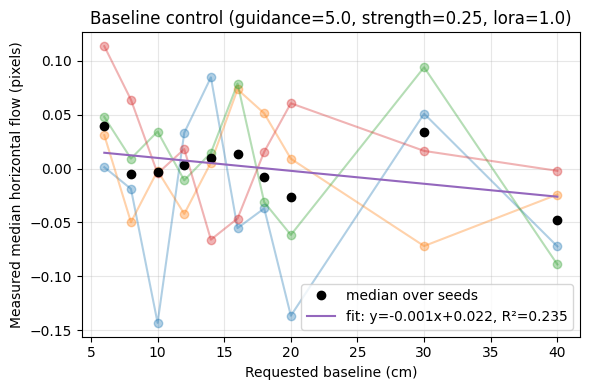

In [ ]:
# Adapter + Scale sind im Eval gesetzt; hier nur Beispielwerte:
df, agg, summary = evaluate_baseline_control(
    txt2img, img2img,
    baselines_cm=(6,8,10,12,14,16,18,20,30,40),
    seeds=(11,22,33,44),
    guidance=5.0,
    strength=0.25,
    W=512, H=512,
    out_dir="/content/baseline_eval",
    lora_scale=1.0,           # 0.8–1.2 testen
    adapter_name="stereo"
)
